# Tarea 3: PINNs, Redes Recurrentes y Transformers 

En esta Tarea Trabajaremos Con [Pytorch](https://pytorch.org/), una librería de Deep Learning de código abierto desarrollada por Facebook. Pytorch es una librería de Deep Learning que se basa en el concepto de [Tensores](https://pytorch.org/docs/stable/tensors.html), que son similares a los arreglos de Numpy, pero con la diferencia de que pueden ser utilizados en una GPU para acelerar los cálculos.

Se escogio Pytorch por sobre Tensorflow o Keras ya que tiene un paquete de [diferenciacion automatica](https://pytorch.org/docs/stable/autograd.html) que nos permite calcular derivadas de forma automatica, lo que nos permite implementar de forma sencilla los modelos de redes neuronales y sobre todo trabajar con PINNs y modificar pequeños detalles de forma sencilla en el lopp de entrenamiento como lo es aplicar custom losses, etc.

Dado que la ultima seccion del curso esta enfocado a trabajar con series temporales, todos los problemas en esta tarea de alguna u otra forma estan relacionados con series temporales o secuencias.

# 1. Imports

In [1]:
#data
import numpy as np
import pandas  as pd
import os

# torch
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
import torch.utils.data as data
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Evaluation 
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error

device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(123)

En esta tarea tenemos 2 Secciones obligatorias, la parte de Redes Recurrentes y la Parte de Transformers, pero como no hay desafio Kaggle se añadio una seccion extra sobre PINNS (Physics Informed Neural Networks) la cual es opcional y sirve como bonus para la nota final.

Dado que no hay desafio Kaggle se incentiva a ser creativos y modificar los codigos, esto tambien añadira un bonus para la tarea.

# Parte 2: Redes Recurrentes

En esta tarea no hay desafio kaggle, por lo que en esta seccion deberan utilizar su creatividad para resolver un problema de series temporales, utilizando redes recurrentes.

## 2.1 Cargar Datos

In [15]:
train_path = os.path.join('data', 'DailyClimate_Train.csv') 
test_path = os.path.join('data', 'DailyClimate_test.csv') 

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

train_df.shape
train_df

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000
...,...,...,...,...,...
1457,2016-12-28,17.217391,68.043478,3.547826,1015.565217
1458,2016-12-29,15.238095,87.857143,6.000000,1016.904762
1459,2016-12-30,14.095238,89.666667,6.266667,1017.904762
1460,2016-12-31,15.052632,87.000000,7.325000,1016.100000


## 2.2 EDA & data Viz

En esta seccion deberan realizar un analisis exploratorio de los datos, generar visualizaciones que les permitan entender mejor los datos con los que estan trabajando y sacar conclusiones de estos.

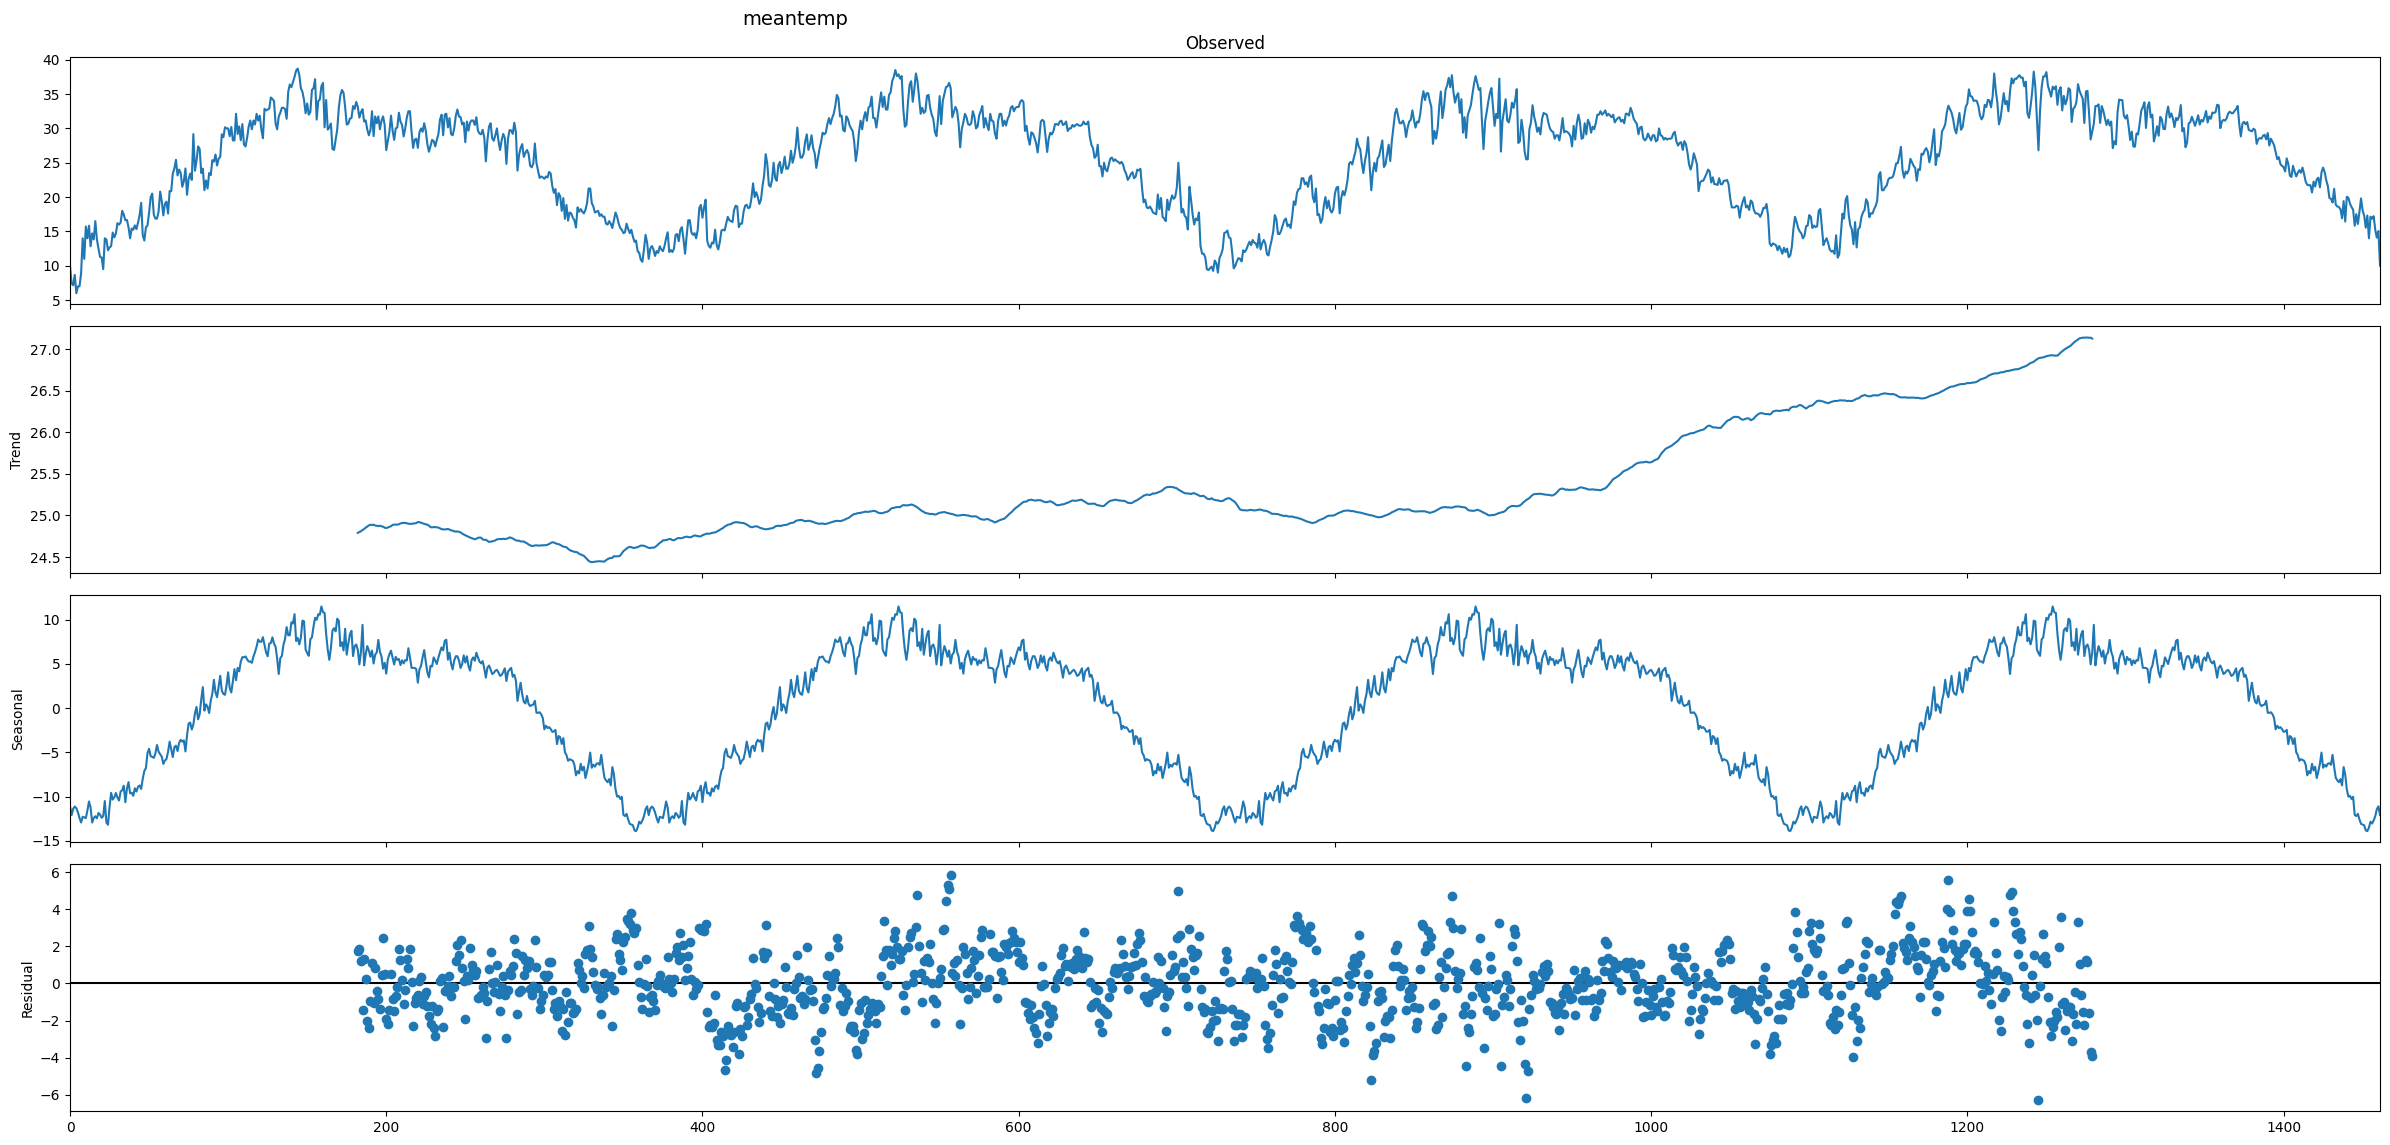

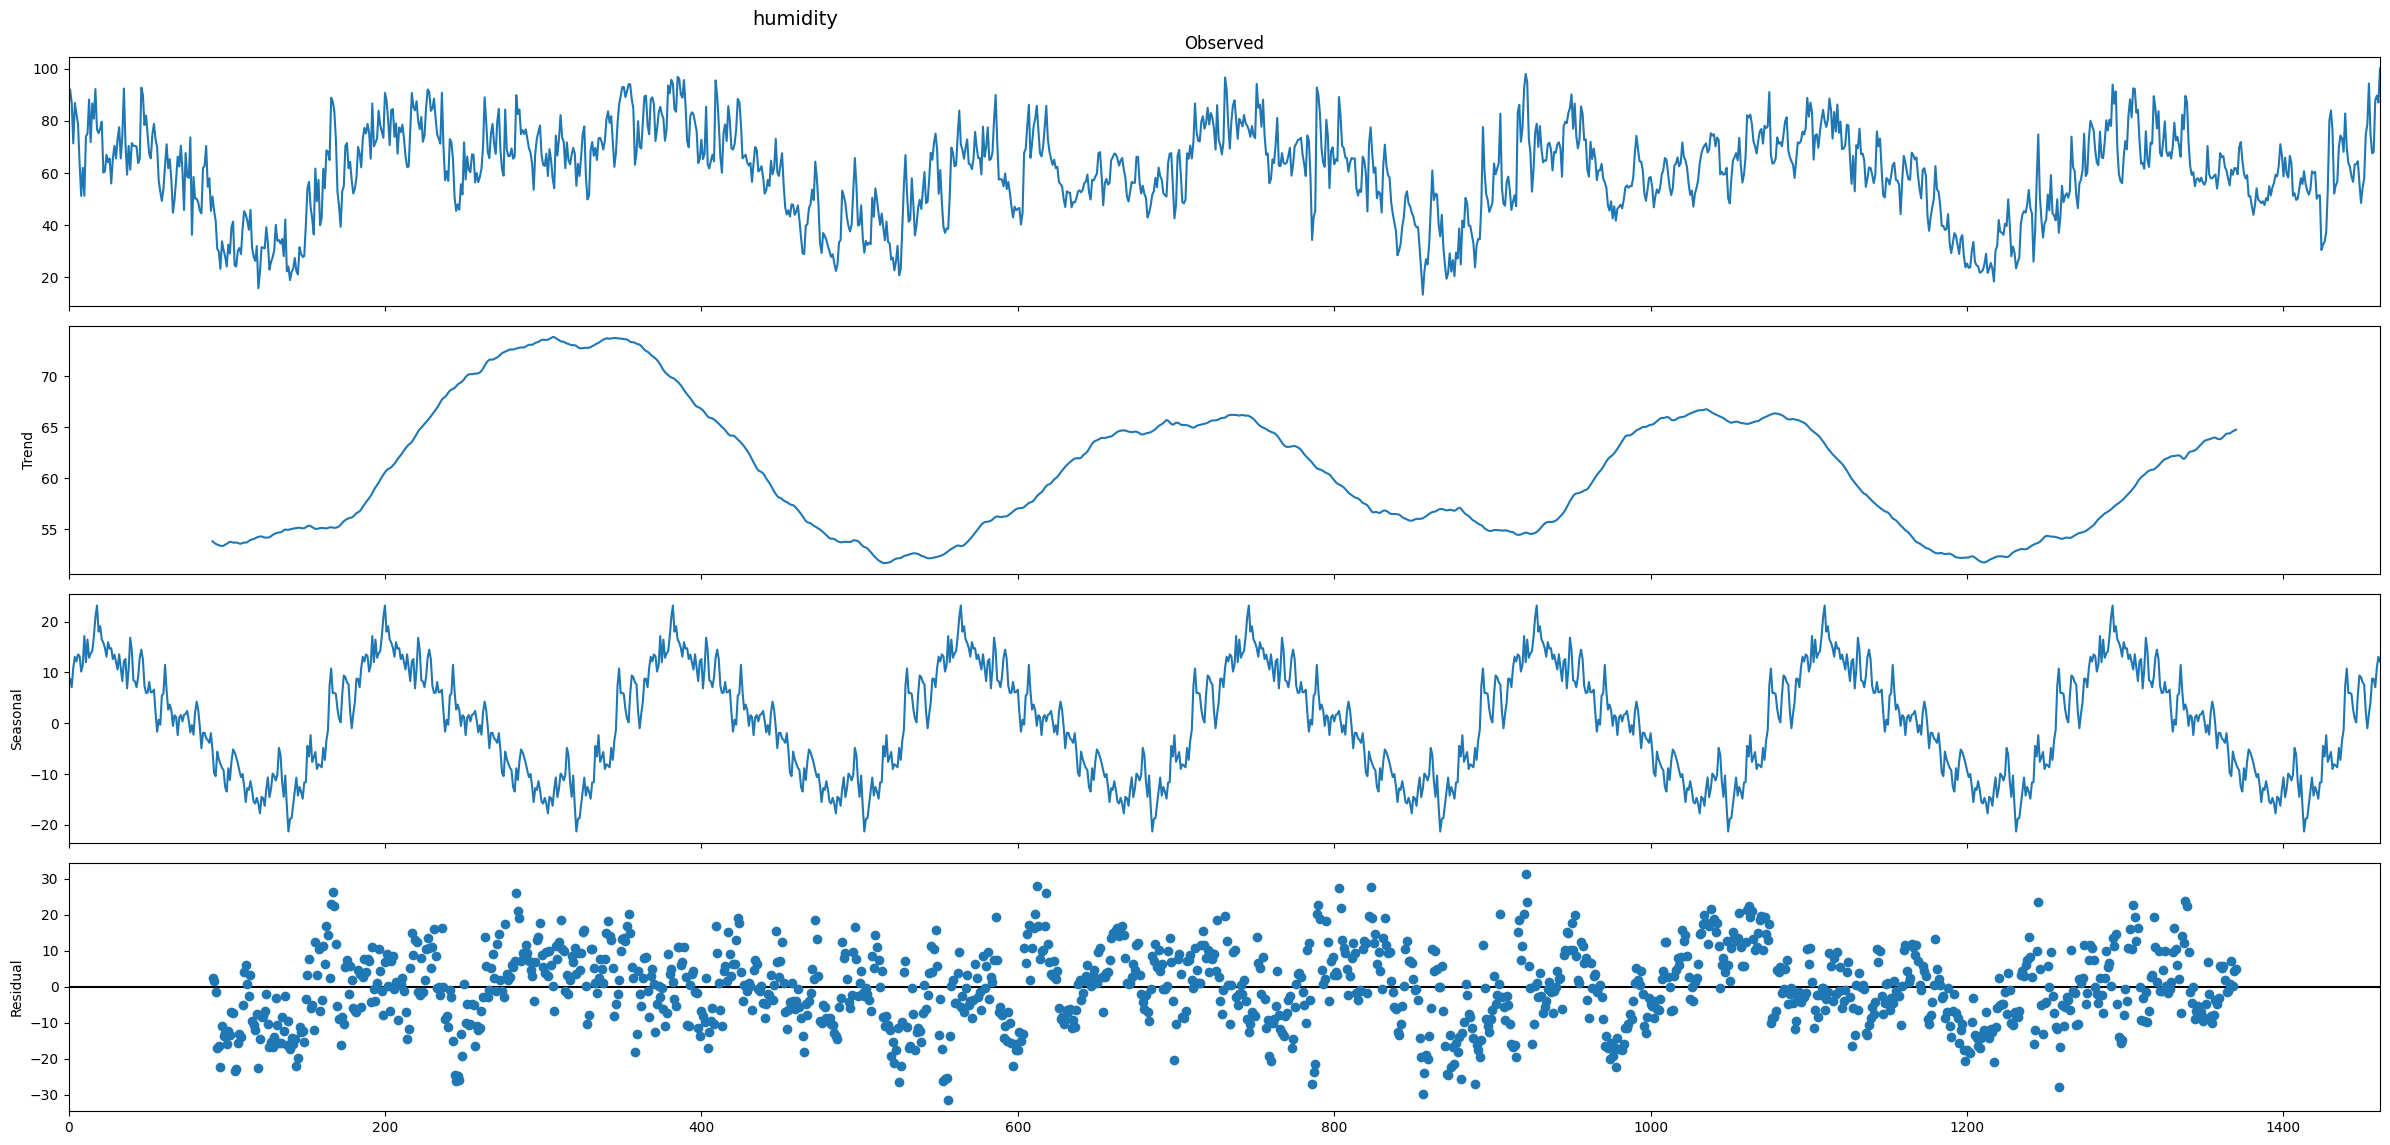

In [118]:
from statsmodels.tsa.seasonal import seasonal_decompose

decompose_result_mt = seasonal_decompose(np.array(train_df['meantemp']), model="additive", period = 365)
decompose_result_hm = seasonal_decompose(np.array(train_df['humidity']), model="additive", period = 182)

plt.rcParams.update({'figure.figsize': (16,12)})
decompose_result_mt.plot().suptitle('meantemp', fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1.5, 1])
decompose_result_hm.plot().suptitle('humidity', fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1.5, 1])

plt.show()

Se descompone la serie la cual se considera como aditivia en sus componentes de tendencia donde se observa que existe una importante componente estacional para cada una,se cumple que la temperatura media tiene un periodo de 365 mientras que la humedad se caracteriza por un periodo de la mitad de la cantidad de días del año.

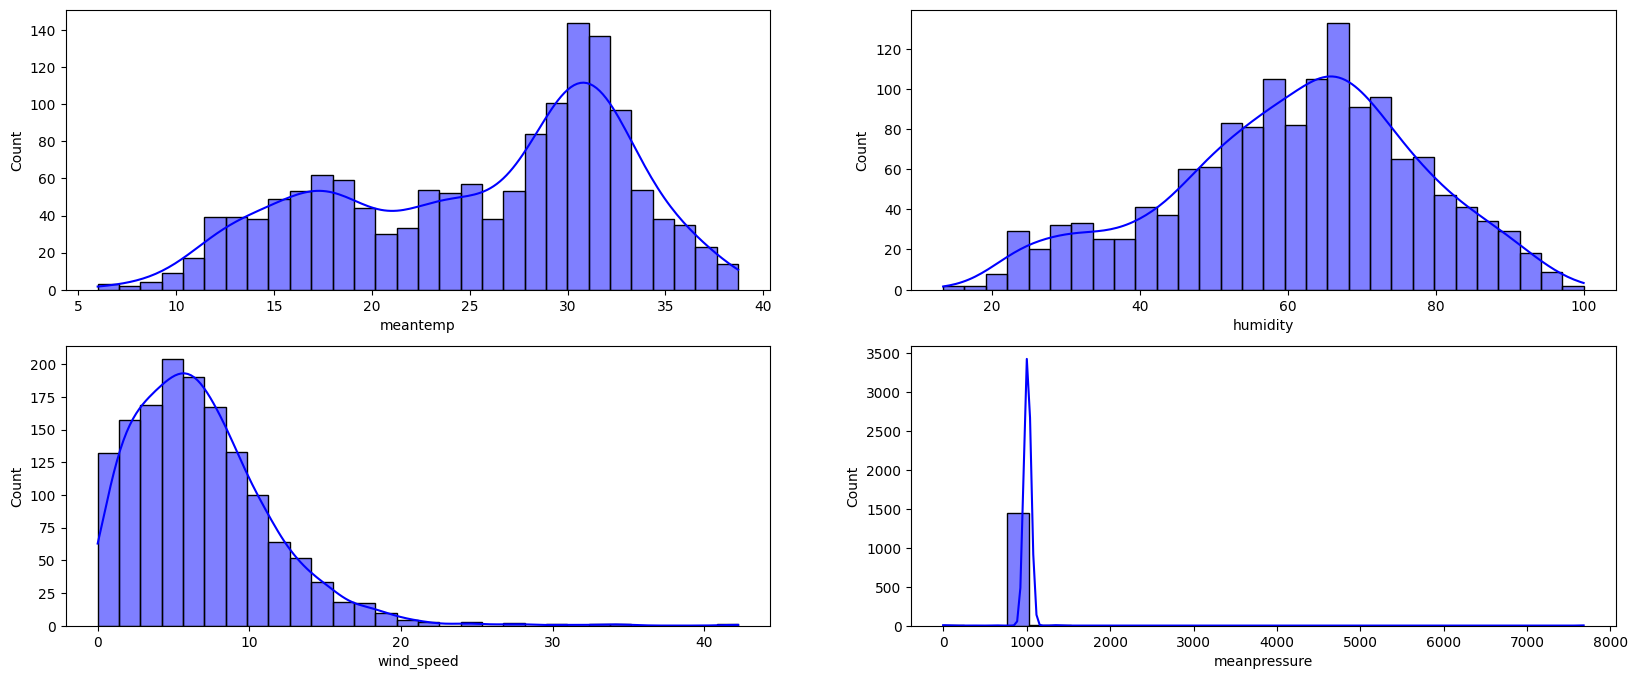

In [109]:
plt.figure(figsize=(20, 8))
names = ['meantemp', 'humidity', 'wind_speed', 'meanpressure']
for i in np.arange(1,5):
    plt.subplot(2, 2, i)
    sns.histplot(train_df[names[i-1]], bins=30, kde=True, color='blue', edgecolor='black')
plt.show()

Respecto a la columna meanpreassure se aprecia que la mayor cantidad de los datos se concentran al rededor de 1000 mientras que existen datos outliers que se escapan del promedio, lo cual no sucede en las otras distribuciones.

In [33]:
column_stats = train_df.describe()
column_stats

,meantemp,humidity,wind_speed,meanpressure
count,1462.000000,1462.000000,1462.000000,1462.000000
mean,25.495521,60.771702,6.802209,1011.104548
std,7.348103,16.769652,4.561602,180.231668
min,6.000000,13.428571,0.000000,-3.041667
25%,18.857143,50.375000,3.475000,1001.580357
50%,27.714286,62.625000,6.221667,1008.563492
75%,31.305804,72.218750,9.238235,1014.944901
max,38.714286,100.000000,42.220000,7679.333333


Mediante un análisis estadistico de cada columna se aprecia que efectivamente la desviación estándar de la columna meanpressure es muy superior a las otras, se realizara un boxplot de dichos datos para observar cuantos outliers existen.

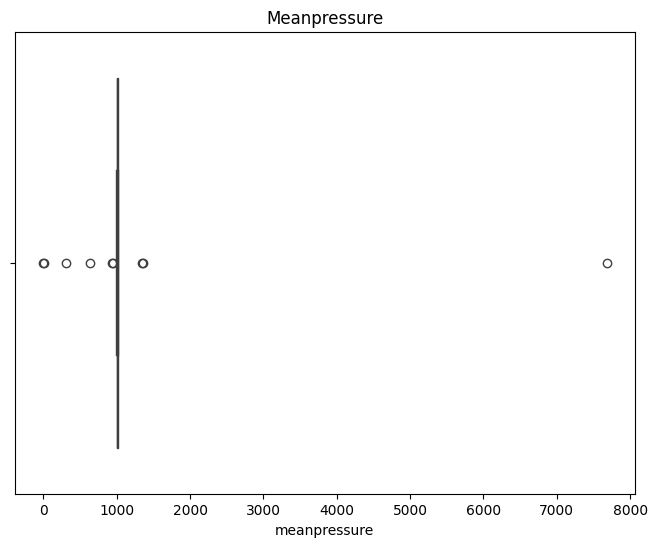

In [39]:
plt.figure(figsize=(8, 6))
sns.boxplot(x=train_df['meanpressure'])
plt.title('Meanpressure')
plt.show()

In [93]:
# Graficos de ejemplo

## 2.3 Preprocesamiento

En esta seccion deberan aplicar las transformaciones necesarias a los datos para poder entrenar su modelo, crear columnas, eliminar columnas, escalar los datos, etc.

In [54]:
def preprocess_time(df, column, period):
    df['sin_'+column] = np.sin(2 * np.pi * df[column] / period)
    df['cos_'+column] = np.cos(2 * np.pi * df[column] / period)
    df.drop([column], axis=1, inplace=True)
    return df

In [55]:
### Start Code Here ###
train_df = pd.read_csv(train_path)
# Convert the 'Date' column to a datetime object
train_df['date'] = pd.to_datetime(train_df['date'])
# Split the 'Date' column into separate 'Year', 'Month', and 'Day' columns
train_df['Year'] = train_df['date'].dt.year
train_df['Month'] = train_df['date'].dt.month
train_df['Day'] = train_df['date'].dt.day
train_df = train_df.drop('date', axis=1)

### Start Code Here ###
test_df = pd.read_csv(test_path)
# Convert the 'Date' column to a datetime object
test_df['date'] = pd.to_datetime(test_df['date'])
# Split the 'Date' column into separate 'Year', 'Month', and 'Day' columns
test_df['Year'] = test_df['date'].dt.year
test_df['Month'] = test_df['date'].dt.month
test_df['Day'] = test_df['date'].dt.day
test_df = test_df.drop('date', axis=1)

In [56]:
yy = train_df.Year.unique()
sin_train = []
cos_train = []
for year in yy:
    dfx = train_df[train_df['Year'] == year]
    if year != '2017':
        df_day = pd.DataFrame(data=np.arange(1, dfx.shape[0]+1), columns=["day"])
        df_day = preprocess_time(df_day, "day", dfx.shape[0]+1)
    else:
        df_day = pd.DataFrame(data=np.arange(1, len(test_df)+1), columns=["day"])
        df_day = preprocess_time(df_day, "day", len(test_df)+1)
        df_day = df_day.iloc[0:1, :]
    sin_train.extend(df_day['sin_day'].tolist())
    cos_train.extend(df_day['cos_day'].tolist())

print(len(sin_train), len(cos_train))

1462 1462


In [57]:
yy = test_df.Year.unique()
sin_test = []
cos_test = []
for year in yy:
    dfx = test_df[test_df['Year'] == year]
    df_day = pd.DataFrame(data=np.arange(1, 365+1), columns=["day"])
    df_day = preprocess_time(df_day, "day", 365+1)
    sin_test.extend(df_day['sin_day'].tolist())
    cos_test.extend(df_day['cos_day'].tolist())

print(len(sin_test[0:114]), len(cos_test[0:114]))

114 114


In [66]:
train_df = pd.read_csv(train_path)
train_df['sin'] = pd.DataFrame(sin_train)
train_df['cos'] = pd.DataFrame(cos_train)

test_df = pd.read_csv(test_path)
test_df['sin'] = pd.DataFrame(sin_test[0:114])
test_df['cos'] = pd.DataFrame(cos_test[0:114])

train_df
test_df

,date,meantemp,humidity,wind_speed,meanpressure,sin,cos
0,2017-01-01,15.913043,85.869565,2.743478,59.000000,0.017166,0.999853
1,2017-01-02,18.500000,77.222222,2.894444,1018.277778,0.034328,0.999411
2,2017-01-03,17.111111,81.888889,4.016667,1018.333333,0.051479,0.998674
3,2017-01-04,18.700000,70.050000,4.545000,1015.700000,0.068615,0.997643
4,2017-01-05,18.388889,74.944444,3.300000,1014.333333,0.085731,0.996318
...,...,...,...,...,...,...,...
109,2017-04-20,34.500000,27.500000,5.562500,998.625000,0.949990,-0.312281
110,2017-04-21,34.250000,39.375000,6.962500,999.875000,0.944489,-0.328542
111,2017-04-22,32.900000,40.900000,8.890000,1001.600000,0.938710,-0.344707
112,2017-04-23,32.875000,27.500000,9.962500,1002.125000,0.932655,-0.360771


In [67]:
objective_col = 'meantemp' # columna objetivo
selected_cols = ['humidity', 'wind_speed', 'meanpressure', 'sin', 'cos']

In [68]:
# En este ejemplo nos quedamos solo con las columnas numericas, pero la idea es que en la lista anterior se incluyan las columnas que se quieran usar para entrenar el modelo, columnas nuevas que hayan creado o modificado en el preprocesamiento.
selected_cols = train_df.drop(columns=objective_col).select_dtypes(include='number').columns.tolist() #solo ejecutar a modo de ejemplo
selected_cols

['humidity', 'wind_speed', 'meanpressure', 'sin', 'cos']

In [69]:
# IMPORTANTE: agregamos la columna objetivo al final de la lista, deben asegurarse de que este al final para el correcto funcionamiento del codigo
selected_cols.append(objective_col) 
selected_cols

['humidity', 'wind_speed', 'meanpressure', 'sin', 'cos', 'meantemp']

In [70]:
tr_timeseries = train_df[selected_cols].values.astype('float32')
te_timeseries = test_df[selected_cols].values.astype('float32')

tr_timeseries#.shape

array([[ 8.4500000e+01,  0.0000000e+00,  1.0156667e+03,  1.7166330e-02,
         9.9985266e-01,  1.0000000e+01],
       [ 9.2000000e+01,  2.9800000e+00,  1.0178000e+03,  3.4327600e-02,
         9.9941063e-01,  7.4000001e+00],
       [ 8.7000000e+01,  4.6333332e+00,  1.0186667e+03,  5.1478755e-02,
         9.9867409e-01,  7.1666665e+00],
       ...,
       [ 8.9666664e+01,  6.2666669e+00,  1.0179048e+03, -3.4234103e-02,
         9.9941385e-01,  1.4095238e+01],
       [ 8.7000000e+01,  7.3249998e+00,  1.0161000e+03, -1.7119560e-02,
         9.9985343e-01,  1.5052631e+01],
       [ 1.0000000e+02,  0.0000000e+00,  1.0160000e+03,  1.2246469e-16,
        -1.0000000e+00,  1.0000000e+01]], dtype=float32)

In [71]:
# concatenamos los dataframes para despues hacer las visualizaciones, No borrar ni modificar
new = pd.concat([train_df, test_df], axis=0).reset_index().drop('index', axis=1)
new_timeseries = new[selected_cols].values.astype('float32')
shape = new_timeseries.shape[1]
new_timeseries.shape

(1576, 6)

In [72]:
# scaling using MinMax
scaler = MinMaxScaler(feature_range=(-1, 1))
# scaler = StandardScaler()
tr_timeseries = scaler.fit_transform(tr_timeseries)
te_timeseries = scaler.transform(te_timeseries)

tr_timeseries

array([[ 6.4191425e-01, -1.0000000e+00, -7.3479342e-01,  1.7166488e-02,
         9.9999928e-01, -7.5545853e-01],
       [ 8.1518161e-01, -8.5883468e-01, -7.3423803e-01,  3.4327917e-02,
         9.9955720e-01, -9.1441047e-01],
       [ 6.9966996e-01, -7.8051478e-01, -7.3401237e-01,  5.1479228e-02,
         9.9882060e-01, -9.2867541e-01],
       ...,
       [ 7.6127613e-01, -7.0314229e-01, -7.3421073e-01, -3.4234416e-02,
         9.9956042e-01, -5.0509465e-01],
       [ 6.9966996e-01, -6.5300810e-01, -7.3468059e-01, -1.7119717e-02,
         1.0000000e+00, -4.4656402e-01],
       [ 1.0000001e+00, -1.0000000e+00, -7.3470664e-01,  1.2246581e-16,
        -1.0000000e+00, -7.5545853e-01]], dtype=float32)

## 2.4 Dataset y DataLoader

In [73]:
def create_dataset(dataset, lookback, shape):
    """Funcion para crear los tensores de entrenamiento y test
    dataset: np.ndarray
    lookback: int (numero de dias a considerar o largo de la secuencia)
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[:,:shape-1][i:i+lookback]
        target = dataset[:, shape-1][i:i+lookback]
        X.append(feature)
        y.append(target)
    # Convierte las listas a np.ndarray antes de convertirlas en tensores
    X = np.array(X)
    y = np.array(y)
    return torch.tensor(X), torch.tensor(y)

In [74]:
lookback = 7 #consideraremos los ultimos 7 dias para predecir el dia siguiente

train, test = tr_timeseries, te_timeseries
X_train, y_train = create_dataset(train, lookback=lookback, shape=shape)
X_test, y_test = create_dataset(test, lookback=lookback, shape=shape)

X_train.shape

torch.Size([1455, 7, 5])

In [75]:
X_train[0:2] # X_train[0] contiene del día 1 al 7, X_train[1] contiene del día 2 al 8 .... 


tensor([[[ 0.6419, -1.0000, -0.7348,  0.0172,  1.0000],
         [ 0.8152, -0.8588, -0.7342,  0.0343,  0.9996],
         [ 0.6997, -0.7805, -0.7340,  0.0515,  0.9988],
         [ 0.3377, -0.9416, -0.7344,  0.0686,  0.9978],
         [ 0.6958, -0.8247, -0.7346,  0.0857,  0.9965],
         [ 0.6026, -0.9299, -0.7342,  0.1028,  0.9948],
         [ 0.5056, -0.7016, -0.7337,  0.1199,  0.9929]],

        [[ 0.8152, -0.8588, -0.7342,  0.0343,  0.9996],
         [ 0.6997, -0.7805, -0.7340,  0.0515,  0.9988],
         [ 0.3377, -0.9416, -0.7344,  0.0686,  0.9978],
         [ 0.6958, -0.8247, -0.7346,  0.0857,  0.9965],
         [ 0.6026, -0.9299, -0.7342,  0.1028,  0.9948],
         [ 0.5056, -0.7016, -0.7337,  0.1199,  0.9929],
         [ 0.1617, -0.6616, -0.7340,  0.1369,  0.9907]]])

In [90]:
loader = data.DataLoader(data.TensorDataset(X_train, y_train), batch_size = 8, shuffle = True) # dataloader para entrenar los modelos de Pytorch

## 2.5 Modelo Recurrente

En esta seccion se implementa uan clase base para modelos recurrentes, pueden utilizar esta clase o pueden modificarla o crear una nueva clase si lo desean, recuerden que hay bonus por creatividad en esta tarea.

In [91]:
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout, bidirectional, rnn_class):
        super().__init__()
        # Verificar que rnn_class es una de las clases de RNN permitidas
        if rnn_class not in [nn.LSTM, nn.GRU, nn.RNN]:
            raise ValueError("rnn_class must be nn.LSTM, nn.GRU, or nn.RNN")

        # Inicializar la capa recurrente con la clase pasada como parámetro
        self.rnn = rnn_class(input_size=input_size,
                             hidden_size=hidden_size,
                             num_layers=num_layers,
                             batch_first=True,
                             bidirectional=bidirectional)
        
        # Calcular la dimensión de salida de la capa recurrente
        # Es doble si es bidireccional
        factor = 2 if bidirectional else 1
        
        self.dropout = nn.Dropout(dropout)
        self.linear1 = nn.Linear(hidden_size * factor, 64) # 
        self.linear2 = nn.Linear(64, 8)
        self.output_linear = nn.Linear(8, 1)
        
    def forward(self, x):
        # LSTM devuelve (output, (h_n, c_n)) mientras que GRU y RNN solo devuelve (output, h_n)
        x, _ = self.rnn(x)
        x = self.dropout(x)
        x = self.linear1(x)
        x = self.linear2(x)
        x = self.output_linear(x)
        return x

## 2.6 Hiperparámetros

Aca pueden variar los hiperparametros de la red recurrente, pueden agregar mas si lo desean, para mas informacion sobre los optimizadores pueden revisar la documentacion de [pytorch Optim](https://pytorch.org/docs/stable/optim.html), y para mas informacion sobre los criterios de perdida pueden revisar la documentacion de [pytorch Loss](https://pytorch.org/docs/stable/nn.html#loss-functions)

In [99]:
# Hiperparametros del modelo
input_size = shape-1 
hidden_size = 128
num_layers = 2
dropout = 0.2
bidirectional = True #puede ser True o False
layer_type = nn.RNN #puede ser nn.RNN, nn.LSTM o nn.GRU

# Modelo
model = RNNModel(input_size, hidden_size, num_layers, dropout, bidirectional, layer_type)

#optimizador
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr = lr, weight_decay = 1e-5)

# loss func: MSE
loss_fn = nn.MSELoss()

## 2.7 Funciones de entrenamiento y evaluacion

En esta seccion se implementan funciones que nos ayudaran a entrenar y evaluar nuestro modelo, Pytorch no implementa metodos como .fit() por ende los tenemos que crear desde cero, al igual que antes sientanse libres de modificar o crear nuevas funciones, para mas informacion sobre el training loop pueden revisar la documentacion de [pytorch Custom Training](https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html#custom-training-loop)

In [79]:
class CustomEarlyStopping:
    """
    Funcion para detener el entrenamiento cuando la loss de validacion no mejora
    """
    def __init__(self, patience=20, delta=0, verbose=False):
        self.patience = patience
        self.delta = delta
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.best_state = None
        self.best_y_pred = None
    
    def __call__(self, val_loss, model, X):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.best_state = model.state_dict()
            with torch.no_grad():
                self.best_y_pred = model(X)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}, score: {self.best_score}')
    
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.best_state = model.state_dict()
            with torch.no_grad():
                self.best_y_pred = model(X)
            self.counter = 0

In [80]:
def train_model(model, optimizer, early_stopping):
    """
    Funcion para entrenar el modelo
    """
    best_score = None
    best_weights = None

    n_epochs = 200

    for epoch in range(n_epochs):
        model.train() # Entrenamiento
        for X_batch, y_batch in loader:
            y_pred = model(X_batch)
            loss = loss_fn(y_pred.squeeze(), y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        model.eval() # Validacion
        with torch.no_grad():
            y_pred = model(X_train) 
            train_rmse = np.sqrt(loss_fn(y_pred, y_train.unsqueeze(2)))
            
            y_pred = model(X_test) 
            test_rmse = np.sqrt(loss_fn(y_pred, y_test.unsqueeze(2)))
            
            if best_score is None or test_rmse < best_score:
                best_score = test_rmse
                best_weights = model.state_dict()
            
            early_stopping(test_rmse, model, X_test)
            
            # Check if early stopping criterion is met
            if early_stopping.early_stop:
                print("Early stopping")
                break
                
        if epoch % 10 == 0:
            print('*'*10, 'Epoch: ', epoch, '\ train RMSE: ', train_rmse, '\ test RMSE', test_rmse)
    
    return model, best_weights

In [81]:
def get_preds(model, best_weights):
    """
    Funcion para obtener las predicciones y desnormalizarlas
    """
    # Usamos los mejores pesos para hacer las predicciones
    if best_weights is not None:
        model.load_state_dict(best_weights)
        
        # Calculamos las predicciones
        with torch.no_grad():
            y_pred_train = model(X_train).clone().detach().cpu().numpy()
            y_pred_test = model(X_test).clone().detach().cpu().numpy()

        # Modificamos las dimensiones de las predicciones para luego graficarlas
        with torch.no_grad():
            train_predictions = np.ones_like(new_timeseries) * np.nan
            train_predictions[lookback: len(train)] = y_pred_train[:,-1,:]
            
            test_predictions = np.ones_like(new_timeseries) * np.nan
            test_predictions[len(train)+lookback:len(new_timeseries)] = y_pred_test[:,-1,:]

        return train_predictions, test_predictions

In [107]:
def plot_predictions(train_predictions, test_predictions, shape):  
    """
    Funcion para graficar las predicciones
    """
    # plot
    plt.figure(figsize=(20,8))
    plt.plot(new_timeseries[:,shape-1], c = 'b', label = 'True')
    plt.plot(train_predictions[:,shape-1], c='r', label = 'Train')
    plt.plot(test_predictions[:,shape-1], c='g', label = 'Test')
    plt.legend()
    plt.show()

In [83]:
def plot_eval(test_predictions, shape):
    """
    Funcion para graficar las predicciones
    """

    eval_df = pd.concat([test_df['meantemp'].reset_index(),pd.Series(test_predictions[:,shape-1][len(train):].reshape(-1).tolist())],axis=1).drop('index',axis=1) #creamos un dataframe con las predicciones y los valores reales

    eval_df.columns = ['real_meantemp', 'pred_meantemp'] #renombramos las columnas

    rmse = np.sqrt(mean_squared_error(eval_df.iloc[7:]['real_meantemp'], eval_df.iloc[7:]['pred_meantemp'])) #calculamos el rmse

    print(f'RMSE: {rmse}')

    fig = go.Figure(data = [ 
        go.Scatter(x = eval_df.index, y = eval_df['real_meantemp'], mode='lines', name = "Actual"),
        go.Scatter(x = eval_df.index, y = eval_df['pred_meantemp'], mode='lines', name="Predicted"),
    ])

    fig.update_layout(
        font = dict(size=17, family="Franklin Gothic"),
        template = 'simple_white',
        title = 'Real & Predicted Temperature'
    )

    fig.show()

## 2.8 Entrenamiento

In [100]:
early_stopping = CustomEarlyStopping(patience=15, verbose=True)
model, model_best_weights = train_model(model, optimizer, early_stopping)

********** Epoch:  0 \ train RMSE:  tensor(0.1313) \ test RMSE tensor(0.1616)
EarlyStopping counter: 1 out of 15, score: -0.16157442331314087
EarlyStopping counter: 1 out of 15, score: -0.1492270678281784
EarlyStopping counter: 2 out of 15, score: -0.1492270678281784
EarlyStopping counter: 3 out of 15, score: -0.1492270678281784
EarlyStopping counter: 4 out of 15, score: -0.1492270678281784
EarlyStopping counter: 5 out of 15, score: -0.1492270678281784
EarlyStopping counter: 6 out of 15, score: -0.1492270678281784
EarlyStopping counter: 7 out of 15, score: -0.1492270678281784
EarlyStopping counter: 8 out of 15, score: -0.1492270678281784
********** Epoch:  10 \ train RMSE:  tensor(0.1157) \ test RMSE tensor(0.1533)
EarlyStopping counter: 9 out of 15, score: -0.1492270678281784
EarlyStopping counter: 10 out of 15, score: -0.1492270678281784
EarlyStopping counter: 11 out of 15, score: -0.1492270678281784
EarlyStopping counter: 12 out of 15, score: -0.1492270678281784
EarlyStopping counte

In [101]:
train_predictions, test_predictions = get_preds(model, model_best_weights)

In [102]:
train_predictions = scaler.inverse_transform(train_predictions)
test_predictions = scaler.inverse_transform(test_predictions)

## 2.9 Evaluacion

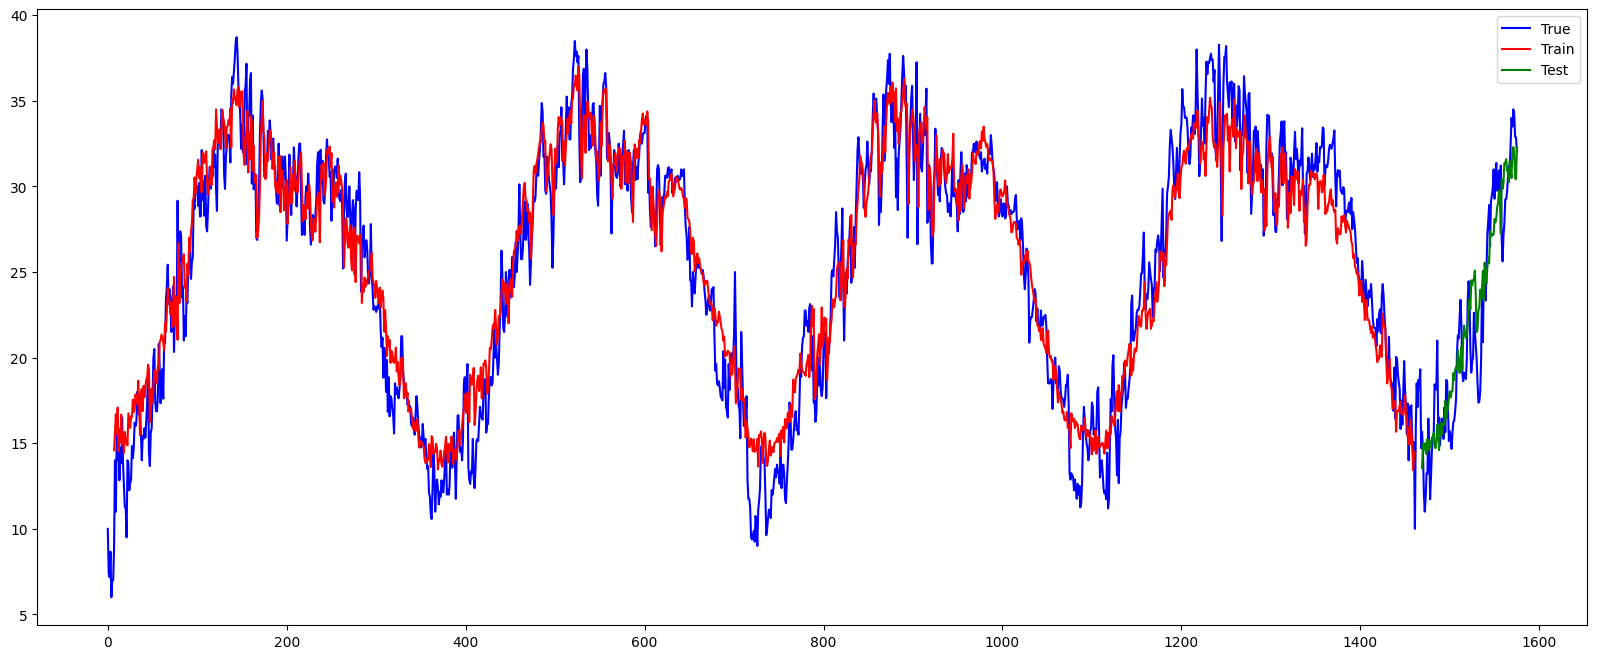

In [108]:
plot_predictions(train_predictions, test_predictions, shape=shape)

In [104]:
plot_eval(test_predictions, shape=shape)


RMSE: 2.536226422939748


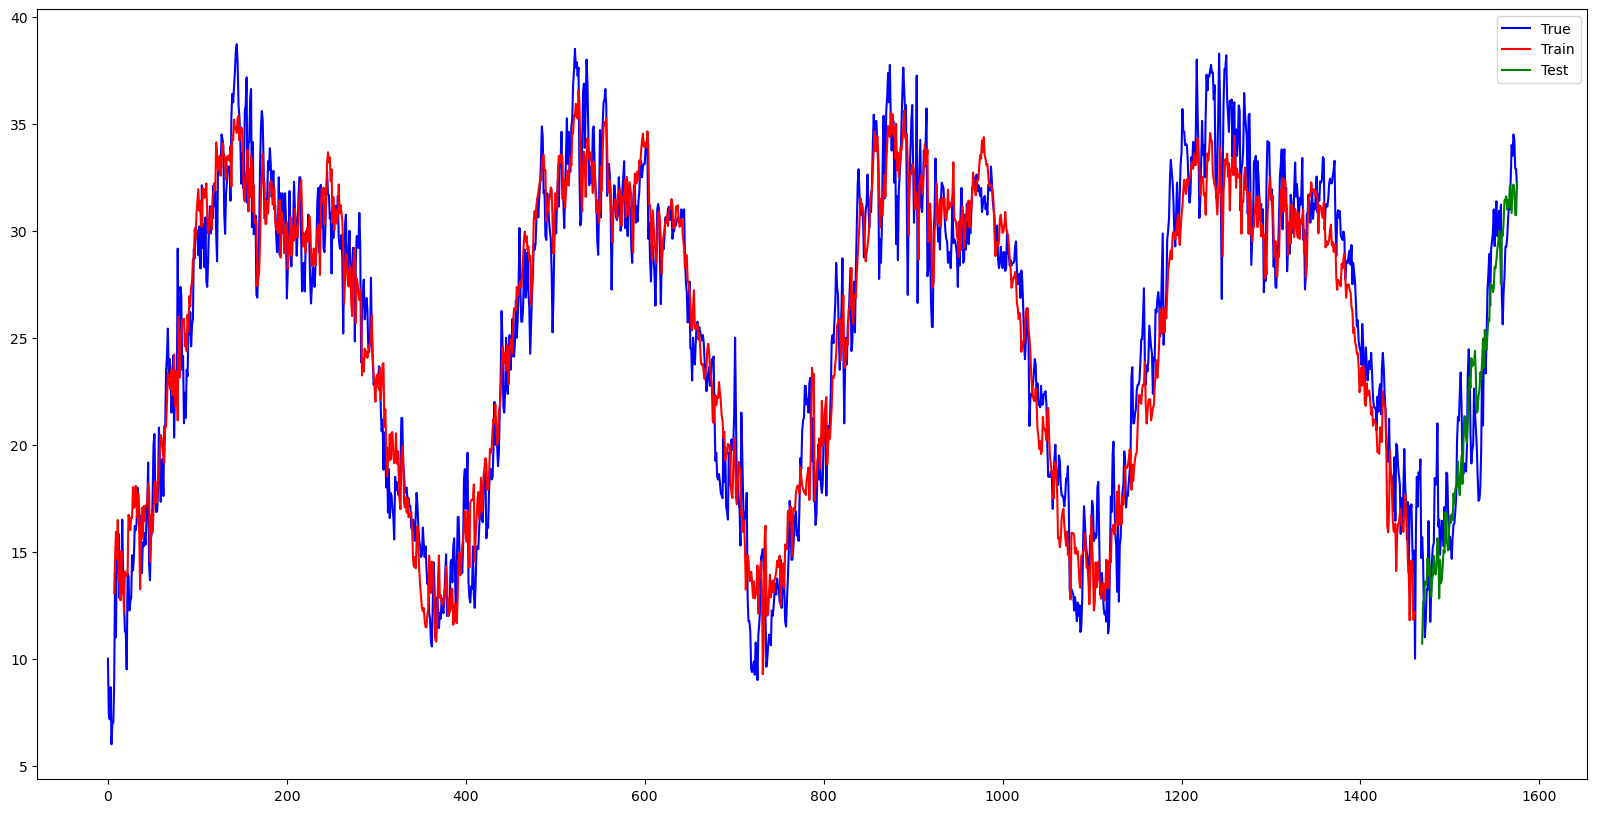

In [130]:
plot_predictions(train_predictions, test_predictions)

In [131]:
plot_eval(test_predictions)

RMSE: 2.504925946161387


# Parte 3: Transformers

Para esta parte vamos a entrenar un transformer muy simple para que aprenda a generar texto como el del Quijote.

### 3.1 Cargar el dataset

In [2]:
import os

current_path = os.getcwd()

# path con archivo el_quijote.txt
data_path = os.path.join(current_path, 'data')
quijote = os.path.join (data_path, 'el_quijote.txt')

In [3]:
with open(quijote, 'r', encoding='utf-8') as f:
    text = f.read()

In [4]:
print("length of dataset in characters: ", len(text))

length of dataset in characters:  1038397


In [5]:
# Visualizamos los primeros 1000 caracteres
print(text[:1000])

DON QUIJOTE DE LA MANCHA
Miguel de Cervantes Saavedra

PRIMERA PARTE
CAPÍTULO 1: Que trata de la condición y ejercicio del famoso hidalgo D. Quijote de la Mancha
En un lugar de la Mancha, de cuyo nombre no quiero acordarme, no ha mucho tiempo que vivía un hidalgo de los de lanza en astillero, adarga antigua, rocín flaco y galgo corredor. Una olla de algo más vaca que carnero, salpicón las más noches, duelos y quebrantos los sábados, lentejas los viernes, algún palomino de añadidura los domingos, consumían las tres partes de su hacienda. El resto della concluían sayo de velarte, calzas de velludo para las fiestas con sus pantuflos de lo mismo, los días de entre semana se honraba con su vellori de lo más fino. Tenía en su casa una ama que pasaba de los cuarenta, y una sobrina que no llegaba a los veinte, y un mozo de campo y plaza, que así ensillaba el rocín como tomaba la podadera. Frisaba la edad de nuestro hidalgo con los cincuenta años, era de complexión recia, sec

### 3.2 Preprocesar el dataset

Vamos a crear un tokenizador muy simple que convierta el texto en una secuencia de números.

In [6]:
chars = sorted(set(text))#TODO #obtener los caracteres unicos del texto
vocab_size = len(chars)
print('Caracteres unicos:',''.join(chars))
print('Largo del vocabulario:',vocab_size)

Caracteres unicos: 
 !"'(),-.0123456789:;<?ABCDEFGHIJKLMNOPQRSTUVWXYZ[]abcdefghijlmnopqrstuvxyz¡«»¿̀́̃̈–‘’“”
Largo del vocabulario: 89


### 3.3 Encoding y Decoding

Ahora que tenemos el tokenizador, vamos a crear una función que nos permita convertir el texto en una secuencia de números y viceversa.

In [7]:
# Mapeamos cada caracter a un entero
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: toma un string, devuelve una lista de enteros
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: toma una lista de enteros, devuelve un string

print(encode("Quijote de la Mancha"))
print(decode(encode("Quijote de la Mancha")))

[40, 71, 60, 61, 65, 70, 56, 1, 55, 56, 1, 62, 52, 1, 36, 52, 64, 54, 59, 52]
Quijote de la Mancha


**pregunta: Que otros tipos de tokenizaciones ademas de por caracteres existen y cuales serian las ventajas?**

Además de la tokenización por caracteres existen también las siguientes formas de tokenizar:

* Tokenización por palabras: Divide el texto por palabras individuales (no caracteres) utilizando espacios y puntuaciones como delimitadores. Dentro de sus ventajas se presenta en la facil comprensión ante lenguajes que tienen bien delimitadas sus palabras (ej: inglés). También tiene una faccil comprensión humana del texto.

* Tokenización por sentencias: Esta tokenización divide el texto en sentencias completas, es decir, serie de palabras que tienen una estructura gramatical independiente. Una de las ventajas de esta tokenización es que al mantener juntas las palabras que forman una sentencia, se conserva el contexto completo para entender el significado completo de esa unidad de texto y también ayuda a evitar ambiguedades que podrían surgir al tratar de interpretar textos fuera del contexto completo de su sentencia.

* Tokenización a nivel Byte: Aquí cada byte de teto es tratado como un token individual, esto permite manejar cualquier secuencia de bytes, incluido el texto con codificación erronea o caracteres especiales. También permite procesar cualquier texto sin necesidad de tener un vocabulario predefinido.

**Pregunta: ¿que otras tecnicas se utilizan antes de tokenizar en problemas de NLP?**

Antes de tokenizar textos se puede realizar lo siguiente:

* Limpiar los datos: Consiste en elimnar caracteres no deseados o incluso signos de puntuación en algunos casos.

* Convertir texto: Otra opción que se puede realizar es convertir el texto a minusculas para reducir la variabilidad de las palabras.

* Normalizar texto: Aplicar una función que normalice los datos de entrada (texto) para que todos estén en el mismo formato.

* Eliminar ruido: En caso de que el texto contenga palabras que no tengan información relevante para el análisis se puede eliminar, ya que se consideran ruido para el problema a tratar.

Además existen otras formas, pero el uso de cada forma de tokenizar dependerá netamente del contexto del problema y los requerimentos que tenga este.

### 3.4 Train y Val Split

In [8]:
# Vamos a Codificar el texto y llevarlo a un tensor de Pytorch
data = torch.tensor(encode(text), dtype=torch.long)

# Separamos en train y validation
n = round(len(data)*0.8)#TODO # % de los datos para entrenar
train_data = data[:n]
val_data = data[n:]

print(train_data.shape, train_data.dtype)
print(train_data[:1000]) # los primeros 1000 caracteres del texto codificado

torch.Size([830718]) torch.int64
tensor([27, 38, 37,  1, 40, 44, 32, 33, 38, 43, 28,  1, 27, 28,  1, 35, 24,  1,
        36, 24, 37, 26, 31, 24,  0, 36, 60, 58, 71, 56, 62,  1, 55, 56,  1, 26,
        56, 68, 72, 52, 64, 70, 56, 69,  1, 42, 52, 52, 72, 56, 55, 68, 52,  0,
         0, 39, 41, 32, 36, 28, 41, 24,  1, 39, 24, 41, 43, 28,  0, 26, 24, 39,
        32, 81, 43, 44, 35, 38,  1, 11, 20,  1, 40, 71, 56,  1, 70, 68, 52, 70,
        52,  1, 55, 56,  1, 62, 52,  1, 54, 65, 64, 55, 60, 54, 60, 65, 81, 64,
         1, 74,  1, 56, 61, 56, 68, 54, 60, 54, 60, 65,  1, 55, 56, 62,  1, 57,
        52, 63, 65, 69, 65,  1, 59, 60, 55, 52, 62, 58, 65,  1, 27,  9,  1, 40,
        71, 60, 61, 65, 70, 56,  1, 55, 56,  1, 62, 52,  1, 36, 52, 64, 54, 59,
        52,  0, 28, 64,  1, 71, 64,  1, 62, 71, 58, 52, 68,  1, 55, 56,  1, 62,
        52,  1, 36, 52, 64, 54, 59, 52,  7,  1, 55, 56,  1, 54, 71, 74, 65,  1,
        64, 65, 63, 53, 68, 56,  1, 64, 65,  1, 67, 71, 60, 56, 68, 65,  1, 52,
       

### 3.5 Generando sequencias de texto

El transformer es una arquitectura de secuencias, por lo que necesitamos generar las secuencias de texto que vamos a utilizar para entrenar el modelo.

In [9]:
batch_size = 4 # cuantas secuencias de texto vamos a procesar en paralelo
block_size = 8 # definimos el largo de nuestra sequencia

def get_batch(split):
    # generamos un batch de datos
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

In [10]:
xb, yb = get_batch('train')
print('inputs:')
print(xb.shape)
print(xb)
print('targets:')
print(yb.shape)
print(yb)

print('----')

for b in range(batch_size): # batch dimension
    for t in range(block_size): # time dimension
        context = xb[b, :t+1]
        target = yb[b,t]
        print(f"cuando el input es {context} el target es: {target}")

inputs:
torch.Size([4, 8])
tensor([[56, 65,  1, 55, 56,  1, 72, 56],
        [65, 69,  1, 55, 56, 62,  1, 63],
        [68, 52, 68, 69, 56,  1, 70, 65],
        [ 9,  1, 36, 56, 70, 60, 65, 81]])
targets:
torch.Size([4, 8])
tensor([[65,  1, 55, 56,  1, 72, 56, 68],
        [69,  1, 55, 56, 62,  1, 63, 71],
        [52, 68, 69, 56,  1, 70, 65, 55],
        [ 1, 36, 56, 70, 60, 65, 81,  1]])
----
cuando el input es tensor([56]) el target es: 65
cuando el input es tensor([56, 65]) el target es: 1
cuando el input es tensor([56, 65,  1]) el target es: 55
cuando el input es tensor([56, 65,  1, 55]) el target es: 56
cuando el input es tensor([56, 65,  1, 55, 56]) el target es: 1
cuando el input es tensor([56, 65,  1, 55, 56,  1]) el target es: 72
cuando el input es tensor([56, 65,  1, 55, 56,  1, 72]) el target es: 56
cuando el input es tensor([56, 65,  1, 55, 56,  1, 72, 56]) el target es: 68
cuando el input es tensor([65]) el target es: 69
cuando el input es tensor([65, 69]) el target es: 1

### 3.6 Creando el modelo

Vamos a crear un modelo naive que consiste en una capa de embedding, y una capa de salida que predice la siguiente palabra

In [11]:
class BigramLanguageModel(nn.Module):

    def __init__(self, vocab_size):
        super().__init__()
        # cada token se representa como un vector de vocab_size dimensiones
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)

    def forward(self, idx, targets=None):

        # idx y targets son (B, T) arrays de indices en el vocabulario
        logits = self.token_embedding_table(idx) # (B,T,C)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            logits, loss = self(idx)
            logits = logits[:, -1, :] 
            probs = F.softmax(logits, dim=-1) 
            idx_next = torch.multinomial(probs, num_samples=1) 
            idx = torch.cat((idx, idx_next), dim=1) 
        return idx

**Pregunta: Explique que hace la funcion Generate (indicar que hace cada linea de la funcion)**


La función genera texto de forma estocástica que extiene una secuencia dada token por token.

En la función tiene como argumentos "idx" que es un tensor que contiene la secuencia inicial de los índices de los tokens y también "max_new_tokens" que indica cuantos nuevos tokens se generarán.

Luego se realiza un for para generar los tokens necesarios. En el for en primer lugar se calculan los logits que son lso vectores de puntuación sin normalizar.

Luego se aplica la función softmax a los logits para obtener la distribución de probabilidad para el próximo token

Después se usa la distribución de probabilidad calculada previamente para seleccionar aleatoriamente un nuevo token, se extrae solo una muestra, pues solo se quiere seleccionar 1 token.

Al final ciclo for se concatena el token de entrada por el nuevo token generado por la función generate y finalmente se retorna de la función el token final que consiste en el token de entrada más la concatenación de los generados.

In [12]:
# Hiperparametros
naive_model = BigramLanguageModel(vocab_size)

lr = 1e-3
optimizer = optim.Adam(naive_model.parameters(), lr = lr, weight_decay = 1e-5) #TODO
batch_size = 32 #TODO
epochs = 50 #TODO

En esta seccion deberan crear un loop de entrenamiento para esto pueden revisar la documentacion de [Pytorch](https://pytorch.org/docs/stable/index.html)

In [13]:


# Entrenamiento
for i in range(epochs):
    # obtenemos un batch de datos
    naive_model.train()
    x,y = get_batch('train')
        
    # Obtenemos las predicciones del modelo y la loss
    #TODO
    logits, loss = naive_model(x, y)
    # reseteamos el gradiente
    #TODO
    optimizer.zero_grad()
    # Backward Pass
    #TODO
    loss.backward()  # Retropropaga la pérdida
    # Actualizamos los pesos
    optimizer.step()  # Actualiza los pesos del modelo#TODO

    # Visualizamos el resultado cada 10 iteraciones
    if i % 10 == 0: 
        print(f"Epoch {i} | Loss {loss.item():.4f}")

Epoch 0 | Loss 4.8997
Epoch 10 | Loss 5.0429
Epoch 20 | Loss 4.9397
Epoch 30 | Loss 4.9919
Epoch 40 | Loss 4.9480


In [14]:
print('loss:', loss.item())
print(decode(naive_model.generate(idx = torch.zeros((1, 1), dtype=torch.long), max_new_tokens=100)[0].tolist()))

loss: 4.941920757293701

QTq464dc9«5te'̃.9.’i5Y9bVo -b?2PK9̃1!4rXG
H6ǹ5’r7qRxz«g)6QQ9n¡1’tAsV3R20“l(‘6N86YKNJFF;(E0H<if;qchn


Como vemos el modelo no es capaaz de generar texto coherente, para esto vamos a utilizar un transformer.

### 3.7 Transformer

El transformer es una arquitectura de secuencias que utiliza atención para poder capturar dependencias de largo plazo, en esta seccion deberan completar las lineas de codigo faltantes, para esto pueden revisar el paper originar [Attention is all you need](https://arxiv.org/pdf/1706.03762.pdf) y la documentacion de [Pytorch](https://pytorch.org/docs/stable/index.html)

In [15]:
n_embd = 512#TODO # dimension de los embeddings
n_head = 8#TODO # numero de cabezas de atencion
n_layer = 6#TODO # numero de capas
dropout = 0.1#TODO # dropout

In [16]:
head_size = n_embd // n_head

In [25]:
class Head(nn.Module):
    """ cabezal de auto-atencion """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size)#TODO
        self.query = nn.Linear(n_embd, head_size) #TODO
        self.value = nn.Linear(n_embd, head_size)#TODO
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)#TODO

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)#TODO
        q = self.query(x)#TODO

        # Calcula la matriz de pesos (Afinidades)
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        softmax = nn.Softmax(dim=-1)(wei)#TODO
        dropout = self.dropout(softmax)#TODO

        # Calcula la ponderacion de los valores por los pesos atencionales
        v = self.value(x)#TODO
        out = dropout @ v #TODO

        
        return out

**Pregunta: En sus propias palabras explique como funciona el mecanismo de auto-atencion**

El mecanismo de auto-atención funciona de la siguiente forma:

* En primer lugar, para cada elemento de la entrada se le asignan tres representaciones vectoriales(query, key y value).

* Luego se calcula un conjunto de puntuaciones de Attention con respecto a todas las claves, esto determina cuanta attention se debe prestar a otros elementos de la secuencia al procesar un elemento.

* Posterior se normaliza las puntuaciones de attention con softmax (así se transforman las salidas en probabilidades)

* Cada valor se pondera por la salida de la softmax y luego se suman los valores ponderados para obtener un vector de salida para cada elemento de la secuencia.

* Finalmente se aplica el MHA 

In [18]:
class MultiHeadAttention(nn.Module):
    """ Multiples cabezales de auto-atencion """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

In [19]:
class FeedFoward(nn.Module):
    """ Capa FeedForward """

    def __init__(self, n_embd):
        super().__init__()
        dff = 4 * n_embd
        self.net = nn.Sequential(
            nn.Linear(n_embd, dff),  # First linear layer
            nn.ReLU(),               # ReLU activation function
            nn.Linear(dff, n_embd)   # Second linear layer to bring it back to embedding dimension size
        )#TODO
        

    def forward(self, x):
        return self.net(x)

In [20]:
class Block(nn.Module):
    """ Bloque de Transformer """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

**Pregunta: Que parte del transformer estamos implementando?** 

Se están implementando dos bloques del transformer. 

* Multi-Head Attention : Como su nombre lo indica, se encarga de hacer la MHA procesando la entrada a través de una capa de normalización, luego una capa de multi attention y la salida de suma a la entrada original para formar una conexión residual.

* Feedforward Network (FFN): representa a la red feedforward. Con la salida residual de la capa de MHA la salida se pasa a la red feedforward.

In [21]:
# Ahora definimos el modelo completo con los bloques de Transformer
class BigramLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -block_size:]
            logits, loss = self(idx_cond)
            logits = logits[:, -1, :] # (B, C)
            probs = F.softmax(logits, dim=-1) # (B, C)
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

**Bonus: Desde que salio el transformer se han publicado mejoras para esta arquitectura, si implementan alguna mejora con la referencia del paper en cuestion obtendran un bonus, se atreven?**

In [38]:
model = BigramLanguageModel()
m = model.to(device)

# Parametros del modelo
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

# Hiperparametros
lr = 1e-3#TODO
optimizer = optim.Adam(model.parameters(), lr = lr, weight_decay = 1e-5) #TODO#TODO
epochs = 800#TODO
eval_interval = 100
eval_iters = 200

19.010649 M parameters


In [39]:
# Funcion de evaluar el modelo 
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

In [40]:
for i in range(epochs):
    # cada 100 iteraciones evaluamos el modelo
    if i % eval_interval == 0 or i == epochs - 1:
        losses = estimate_loss()
        print(f"step {i}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # Obtenemos un batch de datos
    x,y = get_batch('train')#TODO

    # Obtener las predicciones del modelo y la loss
    logits, loss = model(x, y)#TODO

    # reseteamos el gradiente
    optimizer.zero_grad()#TODO

    # Backward Pass
    loss.backward()#TODO

    # Actualizamos los pesos
    optimizer.step()#TODO

step 0: train loss 4.7372, val loss 4.7253
step 100: train loss 2.2482, val loss 2.2796
step 200: train loss 2.1424, val loss 2.1697
step 300: train loss 2.0985, val loss 2.1296
step 400: train loss 2.0531, val loss 2.0819
step 500: train loss 2.0285, val loss 2.0561
step 600: train loss 2.0300, val loss 2.0395
step 700: train loss 1.9973, val loss 2.0156
step 799: train loss 1.9961, val loss 2.0267


In [41]:
# Generamos las predicciones
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=2000)[0].tolist()))


cos enel cabos vera con de denesmuna Dora preman del almeseñiro cuame valcos y baconden esalga pabriar val ejo dicpodo, deseno a estos que el pano de y po ela muce olos quie el o que de for ca carcandunelur ma que ertodo vienle tunes degendidod) Dien con alto erueclo, aque peso, y de sisa con amotiendeseo sue fuijotre y que fondierton-; esu comaŕen con que leso en taucho y estraque e fonte vonezosi quien ele ca entuan lazos mencuencio que yo que con entomerara que fuero lo que sale sila de? Dera, luien lo de En aun jor quin el enlapacero fuy unso peal de porque nuiun de le paque de quellue dal berro de rorquiciare pornacuién despaserose adesprisero de en cuan su lesmola sende esama an dejero pante poruetie en cuesteste la narque que el caban vido la ¿Donde que sofrado el eAs quevena ayo Quijono.
Manto ai puesende brel que anfio caía enta ruen nass y vipondie- so que pandieros, quia quistenda cur an en de deBino, porasi los conoten re Que, precido ca sarbaque vacara toque a el rubi

Ahora las predicciones ya tienen un poco de sentido, podemos seguir entrenando el modelo para que genere texto más coherente y pueden utilizar el modelo cambiando el archivo de input para generar texto de otros libros o de lo que ustedes quieran.